In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Semestre 7/IA-1/Proyecto')
print(os.getcwd())

Mounted at /content/drive
/content/drive/My Drive/Semestre 7/IA-1/Proyecto


#Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from math import floor
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

#Reading the data

In [ ]:
path='./Files/Data/Oficial'
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

In [ ]:
print("Head:")
print(df.head())
print("\n Stats:")
print(df.describe())
print("\n Shape:")
print(df.shape)
print("\n Add_info:")
print(df.info())


Head:
         Date      Open      High       Low     Close
0  04/21/2021  4,128.42  4,175.02  4,126.35  4,173.42
1  04/20/2021  4,159.18  4,159.18  4,118.38  4,134.94
2  04/19/2021  4,179.80  4,180.81  4,150.47  4,163.26
3  04/16/2021  4,174.14  4,191.31  4,170.75  4,185.47
4  04/15/2021  4,139.76  4,173.49  4,139.76  4,170.42

 Stats:
              Date      Open      High       Low     Close
count         2521      2521      2521      2521      2521
unique        2516      2495      2497      2503      2503
top     04/21/2015  1,985.32  2,094.32  2,041.88  2,736.56
freq             2         2         2         3         2

 Shape:
(2521, 5)

 Add_info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2521 entries, 0 to 2520
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    2521 non-null   object
 1   Open    2521 non-null   object
 2   High    2521 non-null   object
 3   Low     2521 non-null   object
 4   Close   

#PreProcesing Data

In order to convert the data of the dataframe to numerically manipulable, the commas must be removed as the '/' character to convert the date column into date_time pandas format.

In [ ]:
df.replace(',','',regex=True, inplace=True)
df.replace('/','',regex=True, inplace=True)

In [ ]:
df.High=df.High.astype('float32')
df.Low=df.Low.astype('float32')
df.Open=df.Open.astype('float32')
df.Close=df.Close.astype('float32')
df['Date'] = pd.to_datetime(df['Date'],format='%m%d%Y')

Now with the data ready to manipulate
Actually in $df$ there is a register of every day that $S_{\text{&}}P500$ is open, about its high, minimum, opening and closing values. But as we can see the market capitalization of the index doesn't have uniform an linear changes over the time.

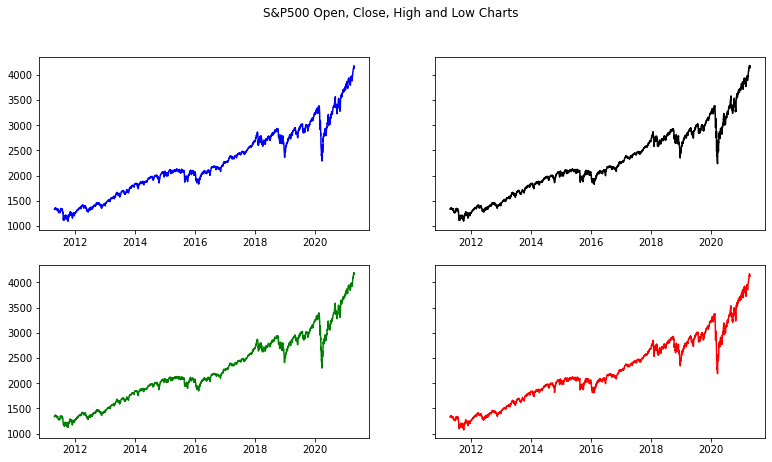

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(13, 7), sharey=True)
fig.suptitle('S&P500 Open, Close, High and Low Charts')

axes[0,0].plot(df.Date,df.Open,color='blue')
axes[0,1].plot(df.Date,df.Close,color='black')
axes[1,0].plot(df.Date,df.High,color='green')
axes[1,1].plot(df.Date,df.Low,color='red')


In order to make a better analysis, we decide to get and use relative values to be processed by the model. So:

Let $h$ be the highest price value in the day, $l$ be the lowest , $o$ the opening price and $c$ the closing price. 
<center>


Then we can define the relative volatility as:


 $v_r=\frac{h-l}{o}$  

and the relative displacement as:

$d_r=\frac{c-o}{o}$

In [ ]:
df['Volatility']= (df.High - df.Low)/df.Open
df['Displacement']= (df.Close - df.Open)/df.Open
df.head()

,Date,Open,High,Low,Close,Volatility,Displacement
0,2021-04-21,4128.419922,4175.020020,4126.350098,4173.419922,0.011789,0.010900
1,2021-04-20,4159.180176,4159.180176,4118.379883,4134.939941,0.009810,-0.005828
2,2021-04-19,4179.799805,4180.810059,4150.470215,4163.259766,0.007259,-0.003957
3,2021-04-16,4174.140137,4191.310059,4170.750000,4185.470215,0.004926,0.002714
4,2021-04-15,4139.759766,4173.490234,4139.759766,4170.419922,0.008148,0.007406


Now we have a complete dataset with relative volatility an displacement per day, so we're getting the slice of the data we're using to train our model.


In [ ]:
df1=df[['Date','Volatility','Displacement']] #Getting the frame
df1=df1.sort_values('Date',ascending=True).reset_index(drop=True)#sorting values by date
df1.head()

,Date,Volatility,Displacement
0,2011-04-21,0.003495,0.003113
1,2011-04-25,0.004547,-0.001413
2,2011-04-26,0.009575,0.007847
3,2011-04-27,0.009819,0.005362
4,2011-04-28,0.005990,0.004890


#Reshaping the data 
The general idea of this project is to use relative values (displacement and volatility) of a given number of days to make a prediction about the next day. So to make a proper reshape of the data there is the problem of knowing how many days we should be using for the prediction. As a possible solution, we suggest analyzing the correlation between the mean of both displacement and volatility for different "windows" of days, contrasting it with the displacement of the day to be predicted.

Firstofall we must get the "Tomorrow Displacement" column

In [ ]:
df2=pd.DataFrame(df1)
df2['TomorrowDisp']=df1[1:]['Displacement'].reset_index(drop=True) #Reset index is used to prevent columns from being concatenated using the index as a "key"
df2.tail()# The last day must not have a "tomorrow"

,Date,Volatility,Displacement,TomorrowDisp
2516,2021-04-15,0.008148,0.007406,0.002714
2517,2021-04-16,0.004926,0.002714,-0.003957
2518,2021-04-19,0.007259,-0.003957,-0.005828
2519,2021-04-20,0.009810,-0.005828,0.010900
2520,2021-04-21,0.011789,0.010900,NaN


In [ ]:
df2=df2[0:2520][:]

#Correlation Vector




Having the following matrix
<center>
$M =\begin{bmatrix} D_1&D_2&...&D_{n-1}&D_n\\D_2&D_3&...&D_n&D_{n+1}\\.&.&.&.&.
\\.&.&.&.&.\\D_{t-n+1} & D_{t-n+2} & ... &D_{t-1} &D_t \end{bmatrix};$


Made as :

$M =\begin{bmatrix} M_1&M_2&...&M_{n-1}&M_n \end{bmatrix}$
</center>


Where

$D_i$: is the data of the day $i$ given by $\begin{bmatrix} d_r & v_r  \end{bmatrix}_i$ (in this case).

$n$:is the number of days to analyze per row

$t$:is the total of days in the dataset


We must find de correlation of each one of $[M_1,M_2,...,M_{n-1}]$ with $M_n$ for different $n$ values, this way we get a correlation vector defined as:


$V=\begin{bmatrix} \rho(M_1,M_n) & \rho(M_2,M_n) &...& \rho(M_{n-1},M_n)\end{bmatrix}$


And to compare for different n values we are using the following metric:

$m=\frac{\|V\|_1}{n} $

In [ ]:
windows=range(2,101,1) 
a=df1[['Displacement']].to_numpy()
t=a.shape[0]

In [ ]:
yd=[]
for n in windows: #where n is the number of total columns
                  #being n the day to predict
  a1=a[0:t-n,:]
  for i in range(0,n,1):
    a1=np.concatenate((a1,a[i+1:t-n+i+1,:]),axis=1)
    if i==n-1: #al acabar de hacer la matriz, se debe sacar el vector de correlaciones
      v=[]
      for j in range(0,n-1,1):
        v.append(np.correlate(a1[:,j],a1[:,n-1])) #Correlacion entre la ultima columna y la columna j
  yd.append(np.mean(np.absolute(v)))


In [ ]:
a=df1[['Volatility']].to_numpy()
yv=[]
for n in windows: #where n is the number of total columns
                  #being n the day to predict
  a1=a[0:t-n,:]
  for i in range(0,n,1):
    a1=np.concatenate((a1,a[i+1:t-n+i+1,:]),axis=1)
    if i==n-1: #al acabar de hacer la matriz, se debe sacar el vector de correlaciones
      v=[]
      for j in range(0,n-1,1):
        v.append(np.correlate(a1[:,j],a1[:,n-1])) #Correlacion entre la ultima columna y la columna j
  yv.append(np.mean(np.absolute(v)))

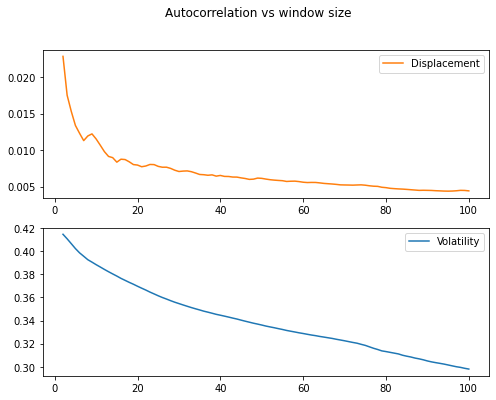

In [ ]:
fig,ax=plt.subplots(2,figsize=(8,6))
fig.suptitle('Autocorrelation vs window size')
ax[0].plot(windows,yd,'tab:orange',label='Displacement')
ax[0].legend()
ax[1].plot(windows,yv,label='Volatility')
ax[1].legend()

The results indicate that the fewer days the greater the magnitude of the correlation vector, however, as taking very few days of entry goes against the objective of the project, it has been decided to carry out tests for multiple windows in different models. Specifically from $n=3$ to $n=8$.

#Displacement (Mean) & TomorrowDisp correlation
As an alternative of the previous process was suggested using the mean of the displacement/volatility of the $n-1$ days of entry to correlate it with the "Tomorrow Displacement" for different windows sizes. But it was also discarded as unique solution because it was considered that the mean of the relative displacement/volatility does not correctly represent the entire entry vector.

In [ ]:
x=np.arange(1,101,1)
yd=[]
yv=[]
for xi in x:
  yd.append(df2.Displacement.rolling(xi).mean().corr(other=df2.TomorrowDisp) )

for xi in x:
  yv.append(df2.Volatility.rolling(xi).mean().corr(other=df2.TomorrowDisp) )

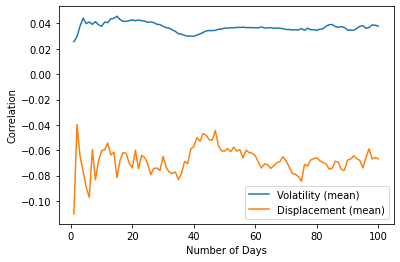

In [ ]:
plt.plot(x,yv,label='Volatility (mean)')
plt.plot(x,yd,label='Displacement (mean)')
plt.ylabel('Correlation')
plt.xlabel('Number of Days')
plt.legend()


It is not very obvious, but the plot leads to suspect that the value we want is between 0 and 10. We must verify it using the following code:

In [ ]:
totalCorr=np.absolute(yv)+np.absolute(yd)
n=np.argmax(totalCorr)+1 #Plus 1 because numpy array index starts in 0, and plus 1 because the window doesnt consider de day n
n

6

Getting $n=6$ from this method

#Datasets with different shapes
Now we must create the dataset shapes from $n=3$ to $n=8$

In [ ]:
n_range=np.arange(3,9,1)
dwl={} #Dictionary of pandas dataframes

for n in n_range:
  a=df1[['Displacement','Volatility']].to_numpy() #Array of each day features
  t=a.shape[0]
  a1=a[0:t-n,:] #Total number of days
  for i in range(0,n,1):
    a1=np.concatenate((a1,a[i+1:t-n+i+1,:]),axis=1)
  
  #Create the columns
  cols=["V_p","D_p"]
  contador=0
  for i in range(0,a1[0].size-2,1):
    if (contador % 2) == 0:
     cols.append('V'+str(int(contador/2)))
    else:
      cols.append('D'+str(int(contador/2 - 0.5)))
    contador+=1
  cols.reverse()
  last_df=pd.DataFrame(a1[:-1,:],columns=cols) #The final data_set
  dwl[n]=last_df

In [ ]:
dwl[3].head()

,D2,V2,D1,V1,D0,V0,D_p,V_p
0,0.003113,0.003495,-0.001413,0.004547,0.007847,0.009575,0.005362,0.009819
1,-0.001413,0.004547,0.007847,0.009575,0.005362,0.009819,0.004890,0.005990
2,0.007847,0.009575,0.005362,0.009819,0.004890,0.005990,0.002551,0.004316
3,0.005362,0.009819,0.004890,0.005990,0.002551,0.004316,-0.002923,0.008783
4,0.004890,0.005990,0.002551,0.004316,-0.002923,0.008783,-0.002309,0.008325


#Multiple models for multiple datasets performance
Now that there are the datasets of different windows sizes, its effectiveness must be tested. And considering that the "real value" ($y_{true}$) for the prediction can take the value of $0$ then there are suggested the following 2 metrics:

Relative percent difference:
$$RPD(y_{pred},y_{true})=2  \frac{y_{pred}-y_{true}}{|y_{pred}|+|y_{true}| }$$
$$-2 \leq RPD \leq 2$$

Relative error of the means:

$$REM(y_{pred},y_{true})=  \frac{\frac{1}{n}\sum^{n}_{i=1}|y_{true,i}-y_{pred,i}|}{\frac{1}{n}\sum^{n}_{i=1}|y_{true,i}|}$$

In [ ]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import *
from sklearn.model_selection import KFold

In [ ]:
def relative_percent_difference(model,X,y_true):
  y_pred = model.predict(X)
  absolute_error = y_true - y_pred
  return np.mean(np.abs(2*absolute_error / (np.abs(y_true)+np.abs(y_pred)))) 

In [ ]:
def relative_error_means(model,X,y_true):
  y_pred = model.predict(X)
  absolute_error = np.abs(y_true - y_pred)
  return np.mean(absolute_error)/np.mean(np.abs(y_true))

##Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
y1=[]
y2=[]
for n in n_range:
  X=dwl[n].iloc[:,:-2] #All data excepting the last two columns
  y=dwl[n]['D_p']
  model1 = DecisionTreeRegressor()
  s = cross_val_score(model1, X, y, cv=KFold(10, shuffle=True), scoring=relative_error_means)
  mean=np.mean(s)
  sdev=np.std(s)
  y1.append(mean)
  y2.append(sdev)
  print("For window of size:",n)
  print ("REM: %.10f (+/- %.12f)"%(mean, sdev))
  print("\n")

For window of size: 3
REM: 1.5126724487 (+/- 0.096352939074)


For window of size: 4
REM: 1.4528803539 (+/- 0.084322021273)


For window of size: 5
REM: 1.4917679992 (+/- 0.117581227267)


For window of size: 6
REM: 1.4698889310 (+/- 0.110754208503)


For window of size: 7
REM: 1.4831267623 (+/- 0.075758018892)


For window of size: 8
REM: 1.5111784791 (+/- 0.093330983309)




Text(0, 0.5, 'REM')

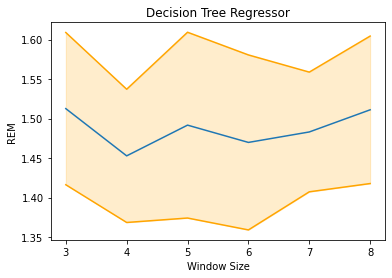

In [ ]:
y1=np.array(y1)
y2=np.array(y2)
plt.title('Decision Tree Regressor')
plt.plot(n_range,y1+y2,color='orange')
plt.plot(n_range,y1)
plt.plot(n_range,y1-y2,color='orange')
plt.fill_between(n_range,y1+y2,y1-y2,alpha=0.2,color='orange')
plt.xlabel('Window Size')
plt.ylabel('REM')

##Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
y3=[]
y4=[]
for n in n_range:
  X=dwl[n].iloc[:,:-2] #All data excepting the last two columns
  y=dwl[n]['D_p']
  model2 = RandomForestRegressor()
  s = cross_val_score(model2, X, y, cv=KFold(10, shuffle=True), scoring=relative_percent_difference)
  mean=np.mean(s)
  sdev=np.std(s)
  y3.append(mean)
  y4.append(sdev)
  print("For window of size:",n)
  print ("RPD: %.10f (+/- %.12f)"%(mean, sdev))
  print("\n")

For window of size: 3
RPD: 1.5842799941 (+/- 0.047300376158)


For window of size: 4
RPD: 1.5825614060 (+/- 0.041651419493)


For window of size: 5
RPD: 1.5862016705 (+/- 0.017569940765)


For window of size: 6
RPD: 1.5841339733 (+/- 0.045932555817)


For window of size: 7
RPD: 1.5997582140 (+/- 0.025141269025)


For window of size: 8
RPD: 1.5973467810 (+/- 0.034816984193)




Text(0, 0.5, 'RPD')

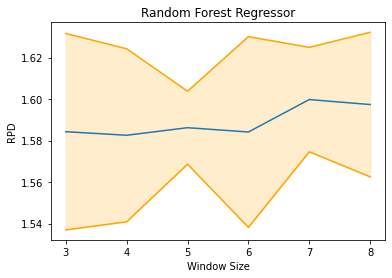

In [ ]:
y3=np.array(y3)
y4=np.array(y4)
plt.title('Random Forest Regressor')
plt.plot(n_range,y3+y4,color='orange')
plt.plot(n_range,y3)
plt.plot(n_range,y3-y4,color='orange')
plt.fill_between(n_range,y3+y4,y3-y4,alpha=0.2,color='orange')
plt.xlabel('Window Size')
plt.ylabel('RPD')

#Support Vector Regressor

In [ ]:
from sklearn.svm import SVR

In [ ]:
y5=[]
y6=[]
for n in n_range:
  X=dwl[n].iloc[:,:-2] #All data excepting the last two columns
  y=dwl[n]['D_p']
  model3 = SVR()
  s = cross_val_score(model3, X, y, cv=KFold(10, shuffle=True), scoring=relative_percent_difference)
  mean=np.mean(s)
  sdev=np.std(s)
  y5.append(mean)
  y6.append(sdev)
  print("For window of size:",n)
  print ("RPD: %.10f (+/- %.12f)"%(mean, sdev))
  print("\n")

For window of size: 3
RPD: 1.4849756372 (+/- 0.053502446078)


For window of size: 4
RPD: 1.4741651583 (+/- 0.043563480115)


For window of size: 5
RPD: 1.4869700596 (+/- 0.039097434541)


For window of size: 6
RPD: 1.4897256173 (+/- 0.053701371673)


For window of size: 7
RPD: 1.4933075347 (+/- 0.070819949321)


For window of size: 8
RPD: 1.4909740533 (+/- 0.054013639192)




Text(0, 0.5, 'RPD')

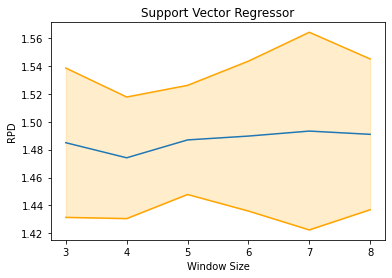

In [ ]:
y5=np.array(y5)
y6=np.array(y6)
plt.title('Support Vector Regressor')
plt.plot(n_range,y5+y6,color='orange')
plt.plot(n_range,y5)
plt.plot(n_range,y5-y6,color='orange')
plt.fill_between(n_range,y5+y6,y5-y6,alpha=0.2,color='orange')
plt.xlabel('Window Size')
plt.ylabel('RPD')

#Deep Neural Networks

In [ ]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(12,)),
    tf.keras.layers.Dense(128, activation=tf.nn.tanh),
    tf.keras.layers.Dense(10, activation=tf.nn.elu)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               1664      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290      
Total params: 2,954
Trainable params: 2,954
Non-trainable params: 0
_________________________________________________________________


In [ ]:

X=dwl[6].iloc[:,:-2] #All data excepting the last two columns
y=dwl[6]['D_p']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

model.compile(optimizer=tf.keras.optimizers.SGD(),  #AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=[tf.metrics.MeanSquaredError()])
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
63/63 [==============================] - 1s 2ms/step - loss: 9.5367e-07 - mean_squared_error: 24.7683
Epoch 2/10
63/63 [==============================] - 0s 2ms/step - loss: 9.5367e-07 - mean_squared_error: 24.7683
Epoch 3/10
63/63 [==============================] - 0s 2ms/step - loss: 9.5367e-07 - mean_squared_error: 24.7683
Epoch 4/10
63/63 [==============================] - 0s 2ms/step - loss: 9.5367e-07 - mean_squared_error: 24.7683
Epoch 5/10
63/63 [==============================] - 0s 3ms/step - loss: 9.5367e-07 - mean_squared_error: 24.7683
Epoch 6/10
63/63 [==============================] - 0s 4ms/step - loss: 9.5367e-07 - mean_squared_error: 24.7683
Epoch 7/10
63/63 [==============================] - 0s 3ms/step - loss: 9.5367e-07 - mean_squared_error: 24.7683
Epoch 8/10
63/63 [==============================] - 0s 4ms/step - loss: 9.5367e-07 - mean_squared_error: 24.7683
Epoch 9/10
63/63 [==============================] - 0s 3ms/step - loss: 9.5367e-07 - mean_square